<a href="https://colab.research.google.com/github/ankitagithub13/capstone-chatbot/blob/Modeling/Capstone_Project_Concatenated_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Concatenated Model - Since the model accuracy for predicting the target variable i.e. Potential Risk Indicator is not that high, we will try and incorporate some additional input parameters apart from the text incident description, and create a concatenated model arhictecture to see if the model accuracy can be improved. 

Based on the prelim. analysis done at the EDA stage, we will incorporate the country, location, time (quarter, week of the day) input variables as predictors in the model, and see if we are able to improve the accuracy score. 

Convolution Model for other parameters

In [60]:
import tensorflow as tf
tf.random.set_seed(100)
import pandas as pd
import numpy as np
from tensorflow import keras 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers.merge import concatenate

In [4]:
import tensorflow.experimental.numpy as tnp

In [ ]:
pip install -U numpy==1.19.2

     |████████████████████████████████| 14.5 MB 4.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [15]:
%cd /content/drive/My Drive/Capstone Project

/content/drive/My Drive/Capstone Project


In [6]:
# let's import the dataset and do the preprocessing
input_data=pd.read_csv('Data Set - industrial_safety_and_health_database_with_accidents_description.csv') 

In [7]:
input_data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [8]:
# Let's drop the Unnamed column 
input_data1=input_data.drop(columns=['Unnamed: 0'],axis=1)

In [9]:
input_data1.head()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


Although there was some sort of variability caused in the actual accident level by 'day of the week' and 'quarter' as seen in the EDA analysis previously, and no insights/ information gain from the 'month' and 'day' towards the target variable -   Let's look at the impact of the 'day of the week', 'quarter', 'month', 'day', 'week in year' against the potential accident level

In [27]:
# Let's extract the relevant time/date features from our dataset

input_data1.Data = pd.to_datetime(input_data1.Data)

input_data1['dayofweek'] =input_data1['Data'].dt.dayofweek
input_data1['quarter'] =input_data1['Data'].dt.quarter
input_data1['day'] =input_data1['Data'].dt.day
input_data1['month'] =input_data1['Data'].dt.month

In [24]:
# Let's reorder the data

input_data2=input_data1[['dayofweek', 'quarter','day','month','Countries', 'Local','Industry Sector', 'Accident Level', 'Potential Accident Level','Genre', 'Employee or Third Party',
                     'Critical Risk','Description']]

In [25]:
input_data2

,dayofweek,quarter,day,month,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,4,1,1,1,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,5,1,2,1,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,1,6,1,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,4,1,8,1,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,6,1,10,1,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,3,4,7,Country_01,Local_04,Mining,I,III,Male,Third Party,Others,"Being approximately 5:00 a.m. approximately, w..."
421,1,3,4,7,Country_01,Local_03,Mining,I,II,Female,Employee,Others,The collaborator moved from the infrastructure...
422,2,3,5,7,Country_02,Local_09,Metals,I,II,Male,Employee,Venomous Animals,During the environmental monitoring activity i...
423,3,3,6,7,Country_02,Local_05,Metals,I,II,Male,Employee,Cut,The Employee performed the activity of strippi...


In [14]:
#'Dayoftheweek' vs. potential accident level Pivot 

dayofweek_table = pd.pivot_table(input_data2, values=['Genre'],index=['dayofweek'], columns=['Potential Accident Level'], 
                             aggfunc=np.count_nonzero, margins=True)

In [15]:
# It seems that there were no link/impact on the potential accident level from the day of the week parameter, although risk seems to be highes in levels 2-4, in day3  
dayofweek_table

Genre                                    
Potential Accident Level     I    II    III     IV     V   VI  All
dayofweek                                                         
0                          3.0  13.0   14.0   22.0   1.0  NaN   53
1                          8.0  19.0   16.0   23.0   4.0  NaN   70
2                         13.0  10.0   18.0   16.0   5.0  1.0   63
3                         11.0  21.0   20.0   23.0   4.0  NaN   79
4                          5.0  14.0   13.0   22.0   8.0  NaN   62
5                          8.0   8.0   13.0   20.0   8.0  NaN   57
6                          1.0  10.0   12.0   17.0   1.0  NaN   41
All                       49.0  95.0  106.0  143.0  31.0  1.0  425

In [16]:
#'Quarter' vs. 'potential accident level' Pivot 

quarter_table = pd.pivot_table(input_data2, values=['Genre'],index=['quarter'], columns=['Potential Accident Level'], 
                             aggfunc=np.count_nonzero, margins=True)

In [17]:
# Again there seems no particular information gain from the quarter feature, though there seems to be a general decrease in risk of accident levels in the 4th quarter, compared to 1st three quarters 

quarter_table

Genre                                    
Potential Accident Level     I    II    III     IV     V   VI  All
quarter                                                           
1                         20.0  24.0   44.0   50.0  15.0  1.0  154
2                         22.0  28.0   36.0   46.0  12.0  NaN  144
3                          5.0  26.0   14.0   22.0   2.0  NaN   69
4                          2.0  17.0   12.0   25.0   2.0  NaN   58
All                       49.0  95.0  106.0  143.0  31.0  1.0  425

In [20]:
#'day' vs. 'potential accident level' Pivot 
# Again there seems to be no particular information gain, and the variabality in a couple of cases seems random

day_table = pd.pivot_table(input_data2, values=['Genre'],index=['day'], columns=['Potential Accident Level'], 
                             aggfunc=np.count_nonzero, margins=True)

In [19]:
day_table

Genre                                    
Potential Accident Level     I    II    III     IV     V   VI  All
day                                                               
1                          2.0   1.0    5.0    6.0   2.0  NaN   16
2                          5.0   1.0    5.0    2.0   2.0  NaN   15
3                          NaN   4.0    2.0    3.0   1.0  NaN   10
4                          2.0   2.0   10.0    5.0   3.0  NaN   22
5                          1.0   5.0    5.0    3.0   NaN  NaN   14
6                          1.0   4.0    3.0    3.0   2.0  NaN   13
7                          1.0   3.0    2.0    3.0   2.0  NaN   11
8                          7.0   5.0    5.0    7.0   1.0  NaN   25
9                          NaN   1.0    5.0    4.0   2.0  NaN   12
10                         NaN   4.0    1.0    7.0   1.0  NaN   13
11                         NaN   4.0    2.0   10.0   2.0  NaN   18
12                         1.0   4.0    3.0    3.0   NaN  NaN   11
13                         1.0   6.0    2.0    6.0   NaN  NaN   15
14                         NaN   3.0    3.0    5.0   1.0  NaN   12
15                         4.0   5.0    2.0    4.0   NaN  NaN   15
16                         5.0   4.0    5.0    5.0   NaN  NaN   19
17                         1.0   4.0    4.0    5.0   1.0  NaN   15
18                         2.0   NaN    5.0    7.0   1.0  NaN   15
19                         NaN   2.0    3.0    6.0   NaN  NaN   11
20                         2.0   2.0    3.0    3.0   1.0  NaN   11
21                         3.0   1.0    4.0    1.0   1.0  NaN   10
22                         2.0   3.0    4.0    7.0   1.0  NaN   17
23                         NaN   5.0    4.0    8.0   NaN  NaN   17
24                         1.0   4.0    3.0    5.0   3.0  NaN   16
25                         4.0   2.0    2.0    4.0   2.0  1.0   15
26                         2.0   3.0    1.0    3.0   NaN  NaN    9
27                         NaN   2.0    2.0    4.0   1.0  NaN    9
28                         1.0   1.0    3.0    1.0   NaN  NaN    6
29                         NaN   2.0    4.0    6.0   NaN  NaN   12
30                         1.0   7.0    1.0    4.0   1.0  NaN   14
31                         NaN   1.0    3.0    3.0   NaN  NaN    7
All                       49.0  95.0  106.0  143.0  31.0  1.0  425

In [21]:
#'Month' vs. 'potential accident level' Pivot 
month_table = pd.pivot_table(input_data2, values=['Genre'],index=['month'], columns=['Potential Accident Level'], 
                             aggfunc=np.count_nonzero, margins=True)

In [22]:
# There seems to be no particular insight, apart from some random variability 
month_table

Genre                                    
Potential Accident Level     I    II    III     IV     V   VI  All
month                                                             
1                          5.0   3.0   16.0   15.0   NaN  1.0   40
2                          6.0  14.0   15.0   19.0   7.0  NaN   61
3                          9.0   7.0   13.0   16.0   8.0  NaN   53
4                          4.0  13.0   14.0   15.0   6.0  NaN   52
5                          7.0   6.0   10.0   14.0   4.0  NaN   41
6                         11.0   9.0   12.0   17.0   2.0  NaN   51
7                          NaN  10.0    3.0    9.0   2.0  NaN   24
8                          1.0   7.0    7.0    6.0   NaN  NaN   21
9                          4.0   9.0    4.0    7.0   NaN  NaN   24
10                         NaN   4.0    5.0   12.0   NaN  NaN   21
11                         2.0   5.0    1.0    4.0   1.0  NaN   13
12                         NaN   8.0    6.0    9.0   1.0  NaN   24
All                       49.0  95.0  106.0  143.0  31.0  1.0  425

As per the exploratory data analysis, we noted that from the time data, only 'day of the week' and 'quarter' had significance, and therefore we will only use those 2 parameters for our 2nd model which will be concatenated with the text classification model.

In [28]:
# As per our EDA analysis  we are only going to use 4 variable for the augmented model - Day of week, quarter, Countries and Local - we can drop the other variables

input_data3=input_data2[['dayofweek','quarter','Countries','Local']]

In [29]:
input_data3.head()

,dayofweek,quarter,Countries,Local
0,4,1,Country_01,Local_01
1,5,1,Country_02,Local_02
2,2,1,Country_01,Local_03
3,4,1,Country_01,Local_04
4,6,1,Country_01,Local_04


In [30]:
X1=input_data3

In [31]:
# Let's extract the target variable which is the 
y1=pd.DataFrame(input_data2['Potential Accident Level'])

In [32]:
print(X1.shape)
print(y1.shape)

(425, 4)
(425, 1)


In [33]:
# let's convert the country and local columns in the dataset into one-hot encoded values before splitting the data
cat_cols=['Countries','Local']
X2= pd.get_dummies(X1, columns = cat_cols)

In [34]:
print(X2.shape)
X2

(425, 17)


,dayofweek,quarter,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,Local_Local_06,Local_Local_07,Local_Local_08,Local_Local_09,Local_Local_10,Local_Local_11,Local_Local_12
0,4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,6,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
421,1,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
422,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
423,3,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [29]:
y1

,Potential Accident Level
0,IV
1,IV
2,III
3,I
4,IV
...,...
420,III
421,II
422,II
423,II


In [35]:
y1['label'] = y1['Potential Accident Level'].replace({'I':0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':4})

In [40]:
y=y1['label']

In [43]:
y.unique()

array([3, 2, 0, 1, 4])

In [44]:
# Since the target labels are non-binary and we will use categorical crossentropy followed by softmax layer to compile the model, we need to convert the label encoded values to categorial using the keras function
from tensorflow.keras.utils import to_categorical

y2 = to_categorical(y)

In [47]:
y2

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [48]:
y2.shape

(425, 5)

In [49]:
from sklearn.model_selection import train_test_split

In [54]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X2, y2, test_size=0.25, random_state=100)

In [55]:
print(x_train1.shape)
print(x_test1.shape)

(318, 17)
(107, 17)


In [56]:
print(y_train1.shape)
print(y_test1.shape)

(318, 5)
(107, 5)


In [57]:
# We will need to convert the Countries and Local variaables to one-hot encoded values 
x_train1.head()

,dayofweek,quarter,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,Local_Local_06,Local_Local_07,Local_Local_08,Local_Local_09,Local_Local_10,Local_Local_11,Local_Local_12
358,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
319,2,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
351,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
361,4,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
404,6,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [58]:
x_test1.head()

,dayofweek,quarter,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,Local_Local_06,Local_Local_07,Local_Local_08,Local_Local_09,Local_Local_10,Local_Local_11,Local_Local_12
315,6,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
271,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
406,6,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
300,4,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
23,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [59]:
y_train1

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [60]:
y_test1

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1.

We will try building two models in isolation first to see how it performs and then, pick the better performing model for the concatenation.

# First let's try a Conv1D model, and then a vanilla neural network model.

In [62]:
# As per our x_train data, We will include 4 aspects - 1) Day of the week, 2) Quarter of the year 3) Country and 4) Location 
# However, since the Categories - Country and Local have been converted to onehot encoded values, the no. of columns have increased from 4 to 17 as seen above 
# Model 1

Length =17

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()


input_aug= Input(shape=(Length,)) 
input_aug1= tf.expand_dims(input_aug, axis=-1)  #  to add another dimension 

conv1= Conv1D(64, kernel_size=4,activation='relu')(input_aug1)
#drop1=Dropout(0.15)(conv1) ---> did not add any/ much value to the model accuracy, and so excluded from model acrhitecture 
conv2= Conv1D(128, kernel_size=10,activation='relu')(conv1)
#drop2=Dropout(0.15)(conv2)--->did not add any/ much  value to the model accuracy, and so excluded from model acrhitecture 
flat1 = Flatten()(conv2)
dense1= Dense(100,activation='relu')(flat1)
output= Dense(5, activation='softmax')(dense1)

aug_model = Model(inputs=input_aug, outputs=output)
aug_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [63]:
# Let's look at the model summary 
print(aug_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
tf_op_layer_ExpandDims_1 (Te [(None, 17, 1)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 64)            320       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               64100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505 

In [64]:
es = EarlyStopping(monitor='val_loss',verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5',save_best_only=True,save_weights_only=True)

In [66]:
# As noted below the training accuracy for validation is not great i.e. ~ 53% just above randomness, and the validation accuracy is unacceptable and lesser than what a random coin toss would be able to predict 
# i.e. ~37%

history =aug_model.fit(x_train1,y_train1,epochs=200,batch_size=150,validation_data=[x_test1,y_test1],callbacks=[es,mc])

Train on 318 samples, validate on 107 samples
Epoch 1/200
150/318 [=============>................] - ETA: 0s - loss: 1.6171 - acc: 0.1667

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


318/318 [==============================] - 2s 5ms/sample - loss: 1.6037 - acc: 0.2358 - val_loss: 1.5383 - val_acc: 0.4112
Epoch 2/200
318/318 [==============================] - 0s 115us/sample - loss: 1.5203 - acc: 0.4245 - val_loss: 1.4622 - val_acc: 0.3645
Epoch 3/200
318/318 [==============================] - 0s 108us/sample - loss: 1.4410 - acc: 0.3931 - val_loss: 1.4025 - val_acc: 0.3551
Epoch 4/200
318/318 [==============================] - 0s 104us/sample - loss: 1.3783 - acc: 0.3805 - val_loss: 1.3614 - val_acc: 0.3925
Epoch 5/200
318/318 [==============================] - 0s 108us/sample - loss: 1.3512 - acc: 0.4245 - val_loss: 1.3309 - val_acc: 0.4393
Epoch 6/200
318/318 [==============================] - 0s 126us/sample - loss: 1.3250 - acc: 0.4465 - val_loss: 1.3213 - val_acc: 0.4673
Epoch 7/200
318/318 [==============================] - 0s 68us/sample - loss: 1.2912 - acc: 0.4528 - val_loss: 1.3416 - val_acc: 0.4486
Epoch 8/200
318/318 [==============================] - 0

# Now let's try a vanilla Neural Network model to see if we can determine better accuracy

In [67]:
# let's try a normal Dense model 

Length =17

input1_aug= Input(shape=(Length,))

dense1= Dense(50,activation='relu')(input1_aug)
#drop1=Dropout(0.15)(conv1) ---> did not add any/ much value to the model ac accuracy  
dense2= Dense(50,activation='relu')(dense1)
#drop2=Dropout(0.20)(dense2) --->did not add any/ much  value to the model 
#dense3= Dense(100,activation='relu')(dense2) --->did not add any/ much  value to the model
#dense4= Dense(50,activation='relu')(dense2) --->did not add any/ much  value to the model
dense5= Dense(25,activation='relu')(dense2)
#drop2=Dropout(0.30)(dense5) #--->did not add any/ much  value to the model 
output= Dense(5, activation='softmax')(dense5)

aug_model1 = Model(inputs=input1_aug, outputs=output)
aug_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [68]:
es1= EarlyStopping(monitor='val_loss',verbose=1, patience=75)
mc1= ModelCheckpoint('best_model1.h5',save_best_only=True,save_weights_only=True)

In [69]:
history1 =aug_model1.fit(x_train1,y_train1,epochs=200,batch_size=150,validation_data=[x_test1,y_test1],callbacks=[es1,mc1])

Train on 318 samples, validate on 107 samples
Epoch 1/200
150/318 [=============>................] - ETA: 0s - loss: 1.6877 - acc: 0.0933

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


318/318 [==============================] - 1s 2ms/sample - loss: 1.6742 - acc: 0.1289 - val_loss: 1.6178 - val_acc: 0.1963
Epoch 2/200
318/318 [==============================] - 0s 113us/sample - loss: 1.6041 - acc: 0.2704 - val_loss: 1.5777 - val_acc: 0.2523
Epoch 3/200
318/318 [==============================] - 0s 85us/sample - loss: 1.5694 - acc: 0.3302 - val_loss: 1.5393 - val_acc: 0.2523
Epoch 4/200
318/318 [==============================] - 0s 89us/sample - loss: 1.5433 - acc: 0.2987 - val_loss: 1.5049 - val_acc: 0.2804
Epoch 5/200
318/318 [==============================] - 0s 92us/sample - loss: 1.5243 - acc: 0.3050 - val_loss: 1.4810 - val_acc: 0.2897
Epoch 6/200
318/318 [==============================] - 0s 87us/sample - loss: 1.5063 - acc: 0.3145 - val_loss: 1.4652 - val_acc: 0.2897
Epoch 7/200
318/318 [==============================] - 0s 84us/sample - loss: 1.4944 - acc: 0.3145 - val_loss: 1.4541 - val_acc: 0.2617
Epoch 8/200
318/318 [==============================] - 0s 88

Observation - As seen above while the training accuracy of both the models are almost the same i.e. ~ 53%, the validation accuracy of the vanilla neural network model is slightly better at ~43% in the case of Neural network model and hence we will select that model architecture for our concatenated model.

For the concatenated model to expirement, we will have two of the below models and see if there is any value addition and improvement in accuracy: 

1) The bert model will serve as the classifier for the text input i.e. incident description

2) The Neural network model as evidneced from above, will be used to evaluate additional parameters such as 'quarter','day of week', 'country' and 'local'

Let's add the Bert Model

In [6]:
# Bert tokenization class

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [78]:
# his API will offer the encoding, decoding and training of Sentencepiece
#!pip install sentencepiece

In [72]:

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [73]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [1]:
import tensorflow  as tf 

In [2]:
tf.executing_eagerly()

True

In [3]:
!pip install bert-tensorflow

In [4]:
!pip install --upgrade tensorflow_hub

In [7]:
import tensorflow_hub as hub
import bert
import tokenization
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1', trainable=True)

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [10]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    output = bert_layer({'input_word_ids':input_word_ids,
                                                 'input_mask': input_mask, 
                                                 'input_type_ids': segment_ids})
    clf_output = output['pooled_output']
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
# let's load the data 
concat_inputdata =pd.read_csv('Data Set - industrial_safety_and_health_database_with_accidents_description.csv')

In [17]:
# As mentioned above, during the data analysis, we noted that from the time data, only 'day of the week' and 'quarter' had significance, and therefore we will only use those 2 parameters for our model augmentation  

concat_inputdata.Data = pd.to_datetime(concat_inputdata.Data)

concat_inputdata['dayofweek']=concat_inputdata['Data'].dt.dayofweek
concat_inputdata['quarter']=concat_inputdata['Data'].dt.quarter

In [18]:
# Let's reorder the data

concat_inputdata1=concat_inputdata[['dayofweek', 'quarter','Countries', 'Local','Industry Sector', 'Accident Level', 'Potential Accident Level','Genre', 'Employee or Third Party',
                     'Critical Risk','Description']]

In [19]:
concat_inputdata1.head()

,dayofweek,quarter,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,4,1,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,5,1,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,1,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,4,1,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,6,1,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [20]:
# we Will need to first split the predictor and label variables; predictor variables can be split into two sets- i.e. 1 with the sentence group and the other with the augmented variables for pre-processing  

X_concat1=pd.DataFrame(concat_inputdata1['Description'])
X_concat2=pd.DataFrame(concat_inputdata1[['dayofweek','quarter','Countries','Local']])
Y1=pd.DataFrame(concat_inputdata1['Potential Accident Level'])

In [21]:
X_concat1

,Description
0,While removing the drill rod of the Jumbo 08 f...
1,During the activation of a sodium sulphide pum...
2,In the sub-station MILPO located at level +170...
3,Being 9:45 am. approximately in the Nv. 1880 C...
4,Approximately at 11:45 a.m. in circumstances t...
...,...
420,"Being approximately 5:00 a.m. approximately, w..."
421,The collaborator moved from the infrastructure...
422,During the environmental monitoring activity i...
423,The Employee performed the activity of strippi...


In [23]:
Y1.head()

,Potential Accident Level
0,IV
1,IV
2,III
3,I
4,IV


In [24]:
# Let's convert the labels to numeric values, and combin the 6 category risk values with 5 as there are very few values 

Y1['label'] = Y1['Potential Accident Level'].replace({'I' :0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':4})

In [25]:
Y2=Y1['label']
Y2.head()

0    3
1    3
2    2
3    0
4    3
Name: label, dtype: int64

In [26]:
# Let's convert the labels to_categorical formal to run the model

from tensorflow.keras.utils import to_categorical
Y2=pd.DataFrame(to_categorical(Y2))
Y2

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
420,0.0,0.0,1.0,0.0,0.0
421,0.0,1.0,0.0,0.0,0.0
422,0.0,1.0,0.0,0.0,0.0
423,0.0,1.0,0.0,0.0,0.0


In [22]:
import sys
import os

py_file_location = "/content/drive/My Drive/Capstone Project"
sys.path.append(os.path.abspath(py_file_location))

In [27]:
# Let's import the pre_processor.py file which contains the functions for removing spaces, stop words, special charceters, etc..

import pre_processor
from pre_processor import pre_process_data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
# Let's run the pre_process function on the text data

x= pre_process_data()

X_concat1["CleanDescription"] = x.pre_process(X_concat1['Description'], 
                    lower_flag=1,
                    remove_spaces_flag=1, 
                    remove_new_line_flag=1,
                    remove_special_char_flag=1,  
                    remove_numbers_flag=1,  
                    replace_appos_flag=1,
                    remove_stop_words_flag=1,  
                    remove_single_letter_word_flag=1,
                    remove_two_letter_word_flag=1,
                    lemmatize_the_words_flag=0, 
                    stem_the_words_flag=0)

In [31]:
X_concat1.head()

,Description,CleanDescription
0,While removing the drill rod of the Jumbo 08 f...,removing drill rod jumbo maintenance superviso...
1,During the activation of a sodium sulphide pum...,activation sodium sulphide pump piping uncoupl...
2,In the sub-station MILPO located at level +170...,substation milpo located level collaborator ex...
3,Being 9:45 am. approximately in the Nv. 1880 C...,approximately cx personnel begins task unlocki...
4,Approximately at 11:45 a.m. in circumstances t...,approximately circumstances mechanics anthony ...


In [32]:
# let's save the clean text as 1st input variable
input1_contact=pd.DataFrame(X_concat1.CleanDescription)

In [33]:
input1_contact.head()

,CleanDescription
0,removing drill rod jumbo maintenance superviso...
1,activation sodium sulphide pump piping uncoupl...
2,substation milpo located level collaborator ex...
3,approximately cx personnel begins task unlocki...
4,approximately circumstances mechanics anthony ...


In [34]:
# Let's precprocess the 2nd type of input 
# let's convert the country and local columns in the dataset into one-hot encoded values before splitting the data, to feed into the model 

cat_cols1=['Countries','Local']
input2_contact= pd.get_dummies(X_concat2, columns = cat_cols1)

In [35]:
input2_contact.head()

,dayofweek,quarter,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,Local_Local_06,Local_Local_07,Local_Local_08,Local_Local_09,Local_Local_10,Local_Local_11,Local_Local_12
0,4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,6,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [36]:
# let's concatenate the predictor variables i.e. X and then split the data into test and training data so that the sequence is retained. 
input_combined=input1_contact.join(input2_contact)

In [37]:
input_combined.head()

,CleanDescription,dayofweek,quarter,Countries_Country_01,Countries_Country_02,Countries_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,Local_Local_06,Local_Local_07,Local_Local_08,Local_Local_09,Local_Local_10,Local_Local_11,Local_Local_12
0,removing drill rod jumbo maintenance superviso...,4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,activation sodium sulphide pump piping uncoupl...,5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,substation milpo located level collaborator ex...,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,approximately cx personnel begins task unlocki...,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,approximately circumstances mechanics anthony ...,6,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [38]:
# Let's split the dataset

from sklearn.model_selection import train_test_split

x_train21, X_test21, y_train21, y_test21 = train_test_split(input_combined,Y2, test_size=0.25, random_state=200)

In [39]:
print(x_train21.shape)
print(X_test21.shape)

(318, 18)
(107, 18)


In [40]:
print(y_train21.shape)
print(y_test21.shape)

(318, 5)
(107, 5)


In [41]:
x_train21.columns

Index(['CleanDescription', 'dayofweek', 'quarter', 'Countries_Country_01',
       'Countries_Country_02', 'Countries_Country_03', 'Local_Local_01',
       'Local_Local_02', 'Local_Local_03', 'Local_Local_04', 'Local_Local_05',
       'Local_Local_06', 'Local_Local_07', 'Local_Local_08', 'Local_Local_09',
       'Local_Local_10', 'Local_Local_11', 'Local_Local_12'],
      dtype='object')

In [42]:
#split the input training data into the two input categories i.e. 1) Text 2) Country, Location, Time of week and quarter 

xtrain_input1=x_train21['CleanDescription']
xtrain_input2=x_train21.drop('CleanDescription',axis=1,inplace=False)

In [43]:
#split the input testing data into the two input categories i.e. 1) Text 2) Country, Location, Time of week and quarter 

xtest_input1=X_test21['CleanDescription']
xtest_input2=X_test21.drop('CleanDescription',axis=1,inplace=False)

In [45]:
# Let's set the max length to 100 as majority of the data has sentences within 100 word limit, and transform the 1st input train and test data to align with the bert model
max_len = 100
train_input =bert_encode(xtrain_input1, tokenizer, max_len=max_len)

In [46]:
test_input = bert_encode(xtest_input1, tokenizer, max_len=max_len)

In [50]:
# Let's create the Bert model structure 

input_word_ids =tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids =tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

output = bert_layer({'input_word_ids':input_word_ids,'input_mask': input_mask,'input_type_ids': segment_ids})
clf_output = output['pooled_output']
net = tf.keras.layers.Dense(64, activation='relu')(clf_output)

In [51]:
#Length1=100
#input1= Input(shape=(Length1,))
input1=[input_word_ids, input_mask, segment_ids]

In [52]:
# We will use the vanilla neural network as it does seem to perform slightly better than the conv1d network, as tested and seen above. 

Length2 =17

input2= Input(shape=(Length2,))

dense11= Dense(50,activation='relu')(input2) 
dense21= Dense(50,activation='relu')(dense11)
dense31= Dense(25,activation='relu')(dense21)

In [53]:
from keras.layers.merge import Concatenate

In [54]:
#Let's create the Concat model structure 

concat_layer = Concatenate()([net,dense31])
dense_layer= Dense(50, activation='relu')(concat_layer)
output = Dense(5, activation='softmax')(dense_layer)

model = Model(inputs=[input1,input2], outputs=output)

In [55]:
# Let's compile the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [56]:
# Let's look at the model summary 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 100)]        0                                            
______________________________________________________________________________________________

In [61]:
es2 = EarlyStopping(monitor='val_loss',verbose=1, patience=25)

In [62]:
# Let's fit the concat model
history = model.fit(x=[train_input,xtrain_input2], y=y_train21, epochs=50, verbose=1, validation_split=0.2,callbacks=es2)

Epoch 1/50
8/8 [==============================] - 5s 338ms/step - loss: 1.0000 - acc: 0.5748 - val_loss: 1.3931 - val_acc: 0.4062
Epoch 2/50
8/8 [==============================] - 2s 288ms/step - loss: 1.0015 - acc: 0.5906 - val_loss: 1.3788 - val_acc: 0.4375
Epoch 3/50
8/8 [==============================] - 2s 288ms/step - loss: 0.9920 - acc: 0.5787 - val_loss: 1.3775 - val_acc: 0.4219
Epoch 4/50
8/8 [==============================] - 2s 287ms/step - loss: 0.9882 - acc: 0.5866 - val_loss: 1.3867 - val_acc: 0.4531
Epoch 5/50
8/8 [==============================] - 2s 287ms/step - loss: 0.9906 - acc: 0.5787 - val_loss: 1.3856 - val_acc: 0.4531
Epoch 6/50
8/8 [==============================] - 2s 286ms/step - loss: 0.9831 - acc: 0.5945 - val_loss: 1.3989 - val_acc: 0.4375
Epoch 7/50
8/8 [==============================] - 2s 289ms/step - loss: 0.9827 - acc: 0.5906 - val_loss: 1.4349 - val_acc: 0.4375
Epoch 8/50
8/8 [==============================] - 2s 291ms/step - loss: 0.9781 - acc: 0.58

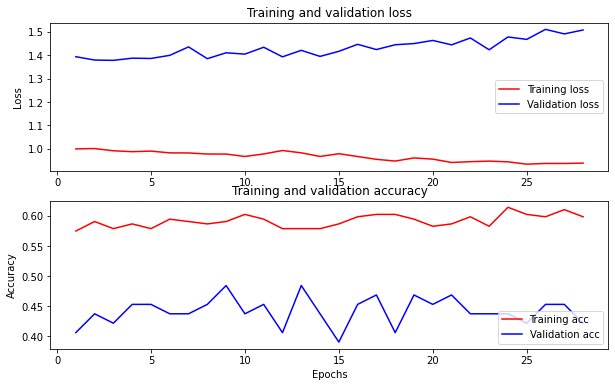

In [65]:
# Let's look at the training/testing accuracy and loss

import matplotlib.pyplot as plt

history_ref = history.history

acc = history_ref['acc']
val_acc = history_ref['val_acc']
loss = history_ref['loss']
val_loss = history_ref['val_loss']

epoch= range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epoch, acc, 'r', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

We note that the accuracy of the concatenated model, while for training is slightly better for testing remains below 50% (i.e. random coin toss), and therefore we sill drop the augmented / additional features from the model - i.e. day of the week, quarter, Country and Location and not go for a concatenated model, rather a model which only has a text classifier based on the incident description inputted.
